# Analysis of Economic Growth and Health Outcomes

This notebook contains the Python code used to generate plots and perform machine learning analysis for the report on the effect of economic growth on health.

--- 
*Modifications by Manus: Added cells to explicitly calculate and display values mentioned in the report.*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.wb as wb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Ensure plots are displayed inline in the notebook
%matplotlib inline

## 1. Data Loading and Preprocessing (from cross_sectional_data.csv)

In [4]:
# Load the dataset
# IMPORTANT: Make sure the path to 'cross_sectional_data.csv' is correct if you run this notebook elsewhere.
# This notebook assumes 'cross_sectional_data.csv' is in the same directory as the notebook, or in a path accessible by Jupyter.
# For the sandbox environment, it will be copied to /home/ubuntu/ before execution for validation.
df_cross_sectional_path = "cross_sectional_data.csv" # Path used in original notebook
# df_cross_sectional_path = "/home/ubuntu/upload/cross_sectional_data.csv" # Alternative for sandbox if needed
try:
    df = pd.read_csv(df_cross_sectional_path)
except FileNotFoundError:
    print(f"Error: '{df_cross_sectional_path}' not found. Please check the file path.")
    df = pd.DataFrame()

df_2015 = pd.DataFrame() # Initialize df_2015
if not df.empty:
    df.rename(columns={"NY.GDP.PCAP.CD": "GDP_per_Capita", "SP.DYN.IMRT.IN": "Infant_Mortality_Rate"}, inplace=True)
    df_2015 = df[df["year"] == 2015].copy()
    df_2015.dropna(subset=["GDP_per_Capita", "Infant_Mortality_Rate"], inplace=True)
    df_2015["GDP_per_Capita"] = pd.to_numeric(df_2015["GDP_per_Capita"], errors='coerce')
    df_2015["Infant_Mortality_Rate"] = pd.to_numeric(df_2015["Infant_Mortality_Rate"], errors='coerce')
    df_2015.dropna(subset=["GDP_per_Capita", "Infant_Mortality_Rate"], inplace=True)
    print("Data from cross_sectional_data.csv loaded and preprocessed successfully.")
    # print(df_2015.head()) # Original notebook prints this, kept for consistency if run interactively
else:
    print("DataFrame from cross_sectional_data.csv is empty. Cannot proceed with 2015 analysis based on this file.")

Data from cross_sectional_data.csv loaded and preprocessed successfully.


### Report Calculation: Data Characteristics for 2015 (from `cross_sectional_data.csv`)

In [6]:
if not df_2015.empty:
    print(f"Number of observations (countries) in df_2015 after cleaning: {len(df_2015)}")
    print(f"Shape of df_2015: {df_2015.shape}")
    print("First 5 rows of df_2015:")
    print(df_2015.head())
else:
    print("df_2015 is empty. Cannot show 2015 data characteristics.")

Number of observations (countries) in df_2015 after cleaning: 225
Shape of df_2015: (225, 6)
First 5 rows of df_2015:
   Unnamed: 0 iso2c                                        country  year  \
0           1    1A                                     Arab World  2015   
1           2    1W                                          World  2015   
2           3    4E    East Asia & Pacific (excluding high income)  2015   
3           4    7E  Europe & Central Asia (excluding high income)  2015   
4           5    8S                                     South Asia  2015   

   GDP_per_Capita  Infant_Mortality_Rate  
0     6545.217753              27.983485  
1    10057.925612              31.700000  
2     6488.381689              14.900000  
3     7033.628566              14.900000  
4     1542.209682              41.900000  


### Report Calculation: Correlation Analysis for 2015 Data (from `cross_sectional_data.csv`)

In [8]:
if not df_2015.empty:
    if 'GDP_per_Capita' in df_2015.columns and 'Infant_Mortality_Rate' in df_2015.columns:
        correlation_gdp_imr_2015 = df_2015['GDP_per_Capita'].corr(df_2015['Infant_Mortality_Rate'])
        print(f"Pearson correlation between GDP per Capita and IMR (2015): {correlation_gdp_imr_2015:.3f}")

        df_2015_log_corr = df_2015.copy()
        # Ensure Log_GDP_per_Capita is created for correlation if not existing from other steps
        if 'Log_GDP_per_Capita' not in df_2015_log_corr.columns and 'GDP_per_Capita' in df_2015_log_corr.columns:
            df_2015_log_corr['Log_GDP_per_Capita'] = np.log(df_2015_log_corr[df_2015_log_corr['GDP_per_Capita'] > 0]['GDP_per_Capita'])
            df_2015_log_corr.dropna(subset=['Log_GDP_per_Capita', 'Infant_Mortality_Rate'], inplace=True) # Important to use same data for both vars
        
        if 'Log_GDP_per_Capita' in df_2015_log_corr.columns:
            correlation_log_gdp_imr_2015 = df_2015_log_corr['Log_GDP_per_Capita'].corr(df_2015_log_corr['Infant_Mortality_Rate'])
            print(f"Pearson correlation between Log GDP per Capita and IMR (2015): {correlation_log_gdp_imr_2015:.3f}")
        else:
            print("Log_GDP_per_Capita column could not be created or found for 2015 correlation.")
    else:
        print("Required columns for 2015 correlation not found in df_2015.")
else:
    print("df_2015 is empty. Cannot calculate 2015 correlations.")

Pearson correlation between GDP per Capita and IMR (2015): -0.543
Pearson correlation between Log GDP per Capita and IMR (2015): -0.789


## 2. Plot 1: Infant Mortality Rate vs. GDP per Capita (Linear Scale)
*Original notebook plot. No changes made.*

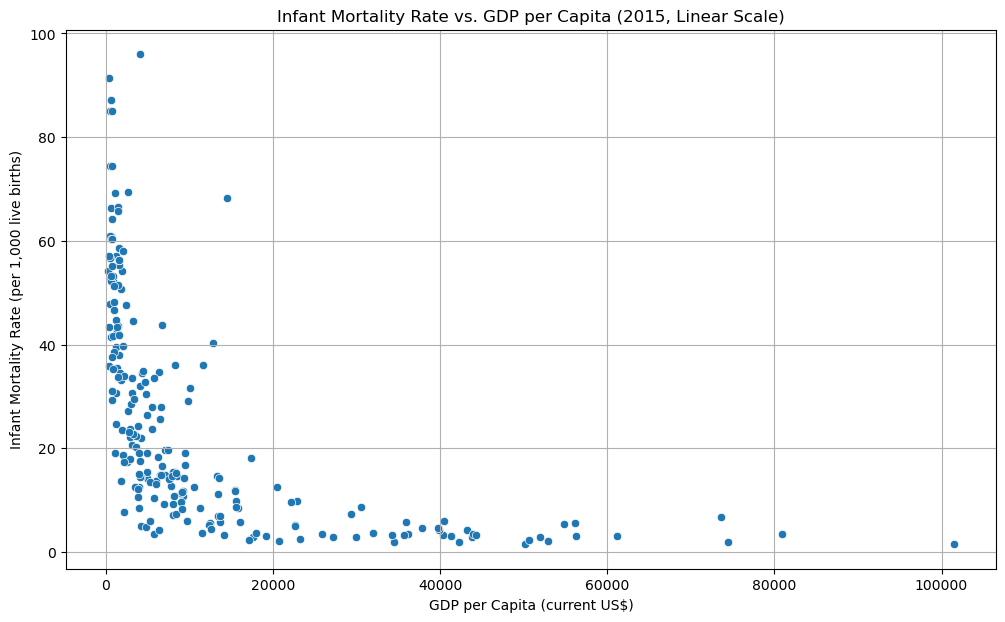

In [10]:
if not df_2015.empty:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_2015, x="GDP_per_Capita", y="Infant_Mortality_Rate")
    plt.title('Infant Mortality Rate vs. GDP per Capita (2015, Linear Scale)')
    plt.xlabel('GDP per Capita (current US$)')
    plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
    plt.grid(True)
    plt.show()
else:
    print("df_2015 is empty. Cannot generate Plot 1.")

## 3. Plot 2: The Preston Curve - Infant Mortality Rate vs. Log GDP per Capita
*Original notebook plot. No changes made.*

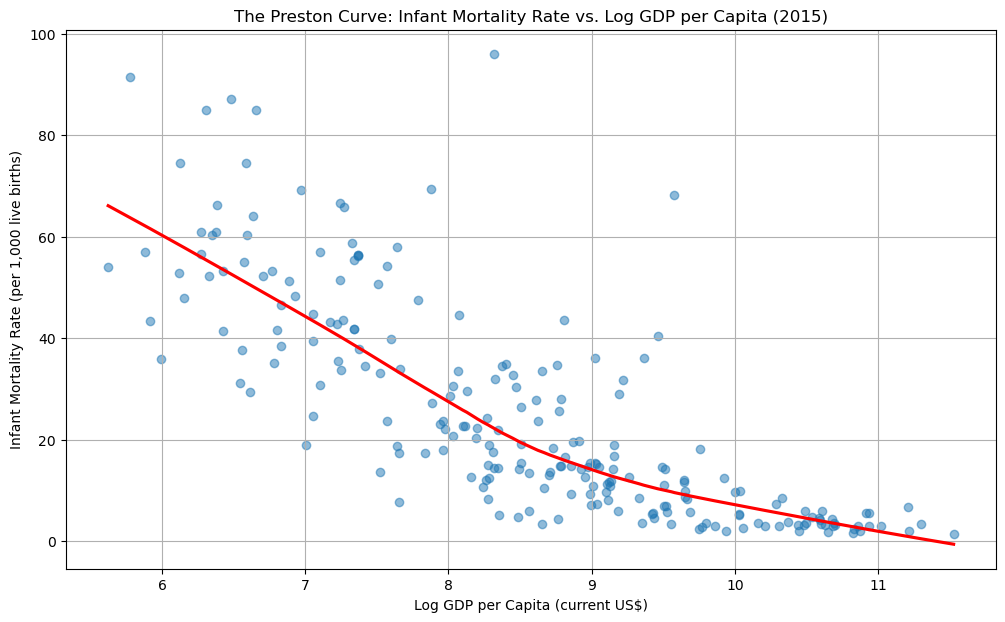

In [12]:
if not df_2015.empty:
    df_2015_plot2 = df_2015.copy() # Use a copy for plot-specific transformations
    df_2015_plot2['Log_GDP_per_Capita'] = np.log(df_2015_plot2['GDP_per_Capita'])
    plt.figure(figsize=(12, 7))
    sns.regplot(data=df_2015_plot2, x='Log_GDP_per_Capita', y='Infant_Mortality_Rate', lowess=True, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('The Preston Curve: Infant Mortality Rate vs. Log GDP per Capita (2015)')
    plt.xlabel('Log GDP per Capita (current US$)')
    plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
    plt.grid(True)
    plt.show()
else:
    print("df_2015 is empty. Cannot generate Plot 2.")

## 4. Machine Learning Analysis for Deeper Insights

### 4.1 K-Means Clustering of Countries by Economic and Health Indicators
*Original notebook K-Means clustering and plot. No changes made to this cell's logic.*

C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


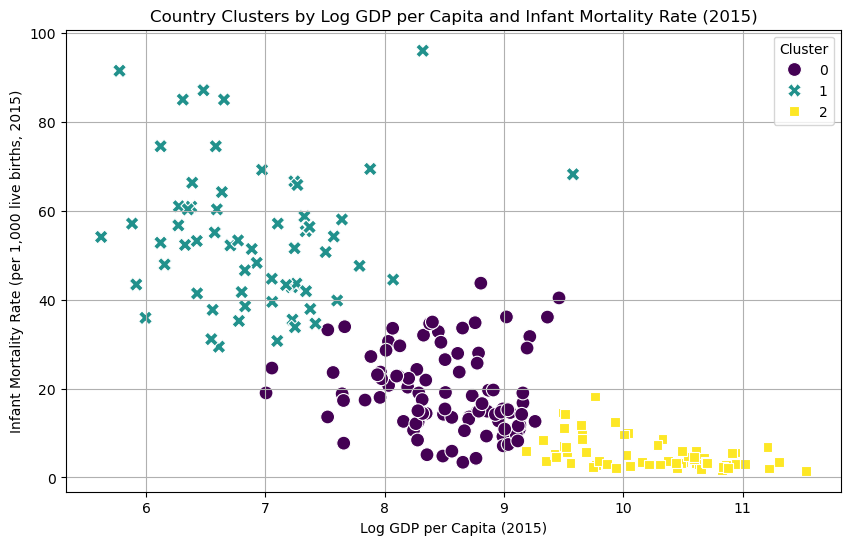

In [15]:
if not df_2015.empty:
    df_2015_cluster = df_2015.copy()
    if 'Log_GDP_per_Capita' not in df_2015_cluster.columns:
        df_2015_cluster['Log_GDP_per_Capita'] = np.log(df_2015_cluster['GDP_per_Capita'])
    
    # Ensure no NaNs from log transformation before clustering
    df_2015_cluster.dropna(subset=['Log_GDP_per_Capita', 'Infant_Mortality_Rate'], inplace=True)

    if not df_2015_cluster.empty:
        X_cluster = df_2015_cluster[['Log_GDP_per_Capita', 'Infant_Mortality_Rate']]
        scaler_cluster = StandardScaler()
        X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)
        
        kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
        df_2015_cluster['Cluster'] = kmeans.fit_predict(X_cluster_scaled)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_2015_cluster, x='Log_GDP_per_Capita', y='Infant_Mortality_Rate', hue='Cluster', palette='viridis', style='Cluster', s=100)
        plt.title('Country Clusters by Log GDP per Capita and Infant Mortality Rate (2015)')
        plt.xlabel('Log GDP per Capita (2015)')
        plt.ylabel('Infant Mortality Rate (per 1,000 live births, 2015)')
        plt.grid(True)
        plt.show()
        # print(df_2015_cluster['Cluster'].value_counts()) # Original notebook might have this for verification
    else:
        print("df_2015_cluster is empty after processing. Cannot perform K-Means.")
else:
    print("df_2015 is empty. Cannot perform K-Means clustering.")

### Report Calculation: K-Means Clustering - Cluster Counts (2015 data)

In [17]:
if 'df_2015_cluster' in locals() and 'Cluster' in df_2015_cluster.columns:
    print("Cluster distribution for K-Means (k=3) on 2015 data:")
    print(df_2015_cluster['Cluster'].value_counts().sort_index())
else:
    print("K-Means clustering results (df_2015_cluster) not found. Run K-Means cell first.")

Cluster distribution for K-Means (k=3) on 2015 data:
Cluster
0    95
1    65
2    65
Name: count, dtype: int64


### 4.2 Predicting Infant Mortality Rate using Random Forest Regressor
*Original notebook Random Forest training and plot. No changes made to this cell's logic for training/plotting.*

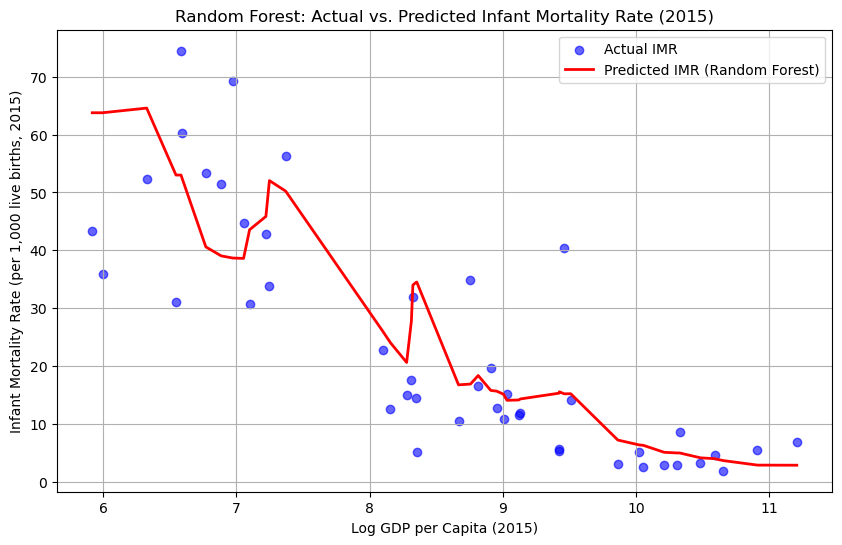

Random Forest (Plot Model) - Test Set MSE: 156.8693


In [19]:
if not df_2015.empty:
    df_2015_rf = df_2015.copy()
    if 'Log_GDP_per_Capita' not in df_2015_rf.columns:
        df_2015_rf['Log_GDP_per_Capita'] = np.log(df_2015_rf['GDP_per_Capita'])
    df_2015_rf.dropna(subset=['Log_GDP_per_Capita', 'Infant_Mortality_Rate'], inplace=True)

    if not df_2015_rf.empty:
        X_rf = df_2015_rf[['Log_GDP_per_Capita']]
        y_rf = df_2015_rf['Infant_Mortality_Rate']
        
        X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
        
        # Original model for plotting (without OOB explicitly requested for this cell by user's notebook)
        rf_model_plot = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=5)
        rf_model_plot.fit(X_train_rf, y_train_rf)
        y_pred_rf_plot = rf_model_plot.predict(X_test_rf)
        
        # Plotting part from original notebook
        plt.figure(figsize=(10, 6))
        plt.scatter(X_test_rf['Log_GDP_per_Capita'], y_test_rf, color='blue', label='Actual IMR', alpha=0.6)
        X_test_sorted_indices = X_test_rf['Log_GDP_per_Capita'].argsort()
        X_test_sorted = X_test_rf['Log_GDP_per_Capita'].iloc[X_test_sorted_indices]
        y_pred_sorted = y_pred_rf_plot[X_test_sorted_indices] # Use predictions from rf_model_plot
        plt.plot(X_test_sorted, y_pred_sorted, color='red', linewidth=2, label='Predicted IMR (Random Forest)')
        plt.title('Random Forest: Actual vs. Predicted Infant Mortality Rate (2015)')
        plt.xlabel('Log GDP per Capita (2015)')
        plt.ylabel('Infant Mortality Rate (per 1,000 live births, 2015)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Original notebook also calculates and prints MSE here for the plot model
        mse_rf_plot = mean_squared_error(y_test_rf, y_pred_rf_plot)
        print(f"Random Forest (Plot Model) - Test Set MSE: {mse_rf_plot:.4f}")
    else:
        print("df_2015_rf is empty after processing. Cannot perform Random Forest.")
else:
    print("df_2015 is empty. Cannot perform Random Forest.")

### Report Calculation: Random Forest Regressor - Metrics (2015 data)
*This cell re-trains the model with `oob_score=True` to get the OOB score and other reported metrics.*

In [21]:
if not df_2015.empty:
    df_2015_rf_metrics = df_2015.copy()
    if 'Log_GDP_per_Capita' not in df_2015_rf_metrics.columns:
        df_2015_rf_metrics['Log_GDP_per_Capita'] = np.log(df_2015_rf_metrics[df_2015_rf_metrics['GDP_per_Capita'] > 0]['GDP_per_Capita'])
    df_2015_rf_metrics.dropna(subset=['Log_GDP_per_Capita', 'Infant_Mortality_Rate'], inplace=True)

    if not df_2015_rf_metrics.empty and 'Log_GDP_per_Capita' in df_2015_rf_metrics.columns:
        X_rf_m = df_2015_rf_metrics[['Log_GDP_per_Capita']]
        y_rf_m = df_2015_rf_metrics['Infant_Mortality_Rate']

        if len(X_rf_m) >= 5: # Ensure enough samples for train/test split and OOB calculation
            X_train_rf_m, X_test_rf_m, y_train_rf_m, y_test_rf_m = train_test_split(X_rf_m, y_rf_m, test_size=0.2, random_state=42)

            # Train Random Forest Regressor with oob_score=True and parameters from report/notebook
            rf_model_metrics = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=5, oob_score=True)
            rf_model_metrics.fit(X_train_rf_m, y_train_rf_m)

            y_pred_rf_m = rf_model_metrics.predict(X_test_rf_m)
            mse_rf_m = mean_squared_error(y_test_rf_m, y_pred_rf_m)
            rmse_rf_m = np.sqrt(mse_rf_m)
            oob_score_rf_m = rf_model_metrics.oob_score_

            print(f"Random Forest (Metrics Model) - Test Set MSE: {mse_rf_m:.4f}")
            print(f"Random Forest (Metrics Model) - Test Set RMSE: {rmse_rf_m:.2f} (Report value for RMSE: 12.52)")
            print(f"Random Forest (Metrics Model) - OOB Score: {oob_score_rf_m:.4f}")

            if hasattr(rf_model_metrics, 'feature_importances_'):
                importances_rf_m = rf_model_metrics.feature_importances_
                print(f"Feature importances (Log_GDP_per_Capita): {importances_rf_m} (Report value: [1.0])")
        else:
            print("Not enough data for Random Forest metrics after processing (need at least 5 samples for OOB).")
    else:
        print("df_2015_rf_metrics is empty or 'Log_GDP_per_Capita' column missing. Cannot calculate RF metrics.")
else:
    print("df_2015 is empty. Cannot calculate RF metrics.")

Random Forest (Metrics Model) - Test Set MSE: 156.8693
Random Forest (Metrics Model) - Test Set RMSE: 12.52 (Report value for RMSE: 12.52)
Random Forest (Metrics Model) - OOB Score: 0.5946
Feature importances (Log_GDP_per_Capita): [1.] (Report value: [1.0])


## 5. Calculations based on World Bank Panel Data (1990-2022, as per Report)
*This section adds calculations based on the World Bank data described in the report, which were not in the original notebook.*

In [23]:
print("--- Loading and Preprocessing World Bank Panel Data (1990-2022) ---")
indicators_wb = {
    'NY.GDP.PCAP.CD': 'GDP_per_Capita_WB',
    'SP.DYN.IMRT.IN': 'Infant_Mortality_Rate_WB'
}
start_year_wb = 1990
end_year_wb = 2022
df_wb_cleaned = pd.DataFrame()

try:
    print(f"Fetching data from World Bank for indicators: {list(indicators_wb.keys())} from {start_year_wb} to {end_year_wb}...")
    df_wb_raw = wb.download(indicator=list(indicators_wb.keys()), country='all', start=start_year_wb, end=end_year_wb)
    df_wb_raw = df_wb_raw.reset_index()
    df_wb_raw.rename(columns=indicators_wb, inplace=True)
    df_wb_raw.rename(columns={'year': 'Year', 'country': 'Country'}, inplace=True)
    df_wb_cleaned = df_wb_raw.dropna(subset=['GDP_per_Capita_WB', 'Infant_Mortality_Rate_WB']).copy()
    df_wb_cleaned['GDP_per_Capita_WB'] = pd.to_numeric(df_wb_cleaned['GDP_per_Capita_WB'], errors='coerce')
    df_wb_cleaned['Infant_Mortality_Rate_WB'] = pd.to_numeric(df_wb_cleaned['Infant_Mortality_Rate_WB'], errors='coerce')
    df_wb_cleaned.dropna(subset=['GDP_per_Capita_WB', 'Infant_Mortality_Rate_WB'], inplace=True)
    print("World Bank panel data loaded and preprocessed successfully.")
    print(f"Shape of df_wb_cleaned: {df_wb_cleaned.shape}")
except Exception as e:
    print(f"Error fetching or processing World Bank data: {e}")

--- Loading and Preprocessing World Bank Panel Data (1990-2022) ---
Fetching data from World Bank for indicators: ['NY.GDP.PCAP.CD', 'SP.DYN.IMRT.IN'] from 1990 to 2022...
World Bank panel data loaded and preprocessed successfully.
Shape of df_wb_cleaned: (7862, 4)


C:\Users\srivalli\AppData\Local\Temp\ipykernel_14152\3620826695.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_wb_raw = wb.download(indicator=list(indicators_wb.keys()), country='all', start=start_year_wb, end=end_year_wb)


### Report Calculation: Descriptive Statistics (World Bank Panel Data 1990-2022, Table 1)

In [25]:
if not df_wb_cleaned.empty:
    print(f"Number of country-year observations for descriptive statistics: {len(df_wb_cleaned)}")
    desc_stats_wb = df_wb_cleaned[['GDP_per_Capita_WB', 'Infant_Mortality_Rate_WB']].describe()
    print("Descriptive Statistics for GDP per Capita and Infant Mortality Rate (1990-2022):")
    print(desc_stats_wb)
    if len(df_wb_cleaned) == 7862:
        print("\nObservation count matches report's stated value (7862).")
    else:
        print(f"\nObservation count ({len(df_wb_cleaned)}) does not match report's stated value (7862).")
else:
    print("World Bank data (df_wb_cleaned) is empty. Cannot calculate descriptive statistics.")

Number of country-year observations for descriptive statistics: 7862
Descriptive Statistics for GDP per Capita and Infant Mortality Rate (1990-2022):
       GDP_per_Capita_WB  Infant_Mortality_Rate_WB
count        7862.000000               7862.000000
mean        10251.407858                 33.904814
std         17763.200759                 30.321081
min            22.952133                  1.400000
25%          1027.667008                  9.500000
50%          3280.456002                 23.400000
75%         10730.737153                 50.800000
max        226052.001905                274.000000

Observation count matches report's stated value (7862).


### Report Calculation: Correlation Analysis (World Bank Panel Data 1990-2022)

In [27]:
if not df_wb_cleaned.empty:
    correlation_gdp_imr_wb = df_wb_cleaned['GDP_per_Capita_WB'].corr(df_wb_cleaned['Infant_Mortality_Rate_WB'])
    print(f"Pearson correlation between GDP per Capita and IMR (1990-2022): {correlation_gdp_imr_wb:.3f} (Report value: -0.461)")

    df_wb_cleaned_log_corr = df_wb_cleaned.copy()
    df_wb_cleaned_log_corr['Log_GDP_per_Capita_WB'] = np.log(df_wb_cleaned_log_corr[df_wb_cleaned_log_corr['GDP_per_Capita_WB'] > 0]['GDP_per_Capita_WB'])
    df_wb_cleaned_log_corr.dropna(subset=['Log_GDP_per_Capita_WB', 'Infant_Mortality_Rate_WB'], inplace=True)
    
    if not df_wb_cleaned_log_corr.empty:
        correlation_log_gdp_imr_wb = df_wb_cleaned_log_corr['Log_GDP_per_Capita_WB'].corr(df_wb_cleaned_log_corr['Infant_Mortality_Rate_WB'])
        print(f"Pearson correlation between Log GDP per Capita and IMR (1990-2022): {correlation_log_gdp_imr_wb:.3f} (Report value: -0.797)")
    else:
        print("Not enough data after log transformation for panel log correlation.")
else:
    print("World Bank data (df_wb_cleaned) is empty. Cannot calculate panel correlations.")

Pearson correlation between GDP per Capita and IMR (1990-2022): -0.461 (Report value: -0.461)
Pearson correlation between Log GDP per Capita and IMR (1990-2022): -0.797 (Report value: -0.797)
